import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
# ^^^ pyforest auto-imports - don't write above this line
### Libraries

In [ ]:
import pandas as pd
# ^^^ pyforest auto-imports - don't write above this line


In [1]:
import pandas as pd
# ^^^ pyforest auto-imports - don't write above this line
import pyforest

In [655]:
from sklearn.tree import DecisionTreeRegressor

In [654]:
from feature_engine import variable_transformers as vt
from feature_engine.discretisers import EqualFrequencyDiscretiser
from feature_engine.categorical_encoders import OrdinalCategoricalEncoder
from feature_engine.categorical_encoders import CountFrequencyCategoricalEncoder
from feature_engine.outlier_removers import Winsorizer
from feature_engine.categorical_encoders import RareLabelCategoricalEncoder

### Data

#### Reading Data

In [637]:
df = pd.read_excel('final.xlsx')

In [638]:
df["Month_Year"] = df['Year'].apply(str).str.cat(df['Month'], sep ="_") 

#### Adding DateTime

In [639]:
date = pd.period_range('2019-01', periods=17, freq='M')
date

PeriodIndex(['2019-01', '2019-02', '2019-03', '2019-04', '2019-05', '2019-06',
             '2019-07', '2019-08', '2019-09', '2019-10', '2019-11', '2019-12',
             '2020-01', '2020-02', '2020-03', '2020-04', '2020-05'],
            dtype='period[M]', freq='M')

In [640]:
df['Month_Year'].value_counts()

2019_Jan    583
2019_Jul    456
2019_Sep    449
2019_Mar    445
2019_Nov    444
2019_Dec    434
2019_Oct    432
2019_Apr    428
2019_Aug    418
2019_May    401
2019_Feb    396
2019_Jun    387
2020_Mar    371
2020_Feb    360
2020_Jan    358
2020_Apr    347
2020_May    316
Name: Month_Year, dtype: int64

In [641]:
seq = [583, 396, 445, 428, 401, 387, 456, 418, 449, 432, 444, 434, 358, 360, 371, 347, 316]

In [642]:
df['Final_Date'] = [item for item, count in zip(date, seq) for i in range(count)]
df = df.set_index('Final_Date') 

#### Creatig More Feature

Average Spend per month for respectice columns

In [643]:
df['Avg_pr_M'] = df.groupby('Final_Date')['Spend'].transform(lambda x : x.mean())
df['Avg_pr_M_pr_Tower'] = df.groupby(['Final_Date', 'Tower'])['Spend'].transform(lambda x : x.mean())
df['Avg_pr_M_pr_Category'] = df.groupby(['Final_Date', 'Category'])['Spend'].transform(lambda x : x.mean())
df['Avg_pr_M_pr_Country'] = df.groupby(['Final_Date', 'Country'])['Spend'].transform(lambda x : x.mean())
df['Avg_pr_M_pr_Region'] = df.groupby(['Final_Date', 'Region'])['Spend'].transform(lambda x : x.mean())
df['Avg_pr_M_pr_Vendor'] = df.groupby(['Final_Date', 'Supplier Name'])['Spend'].transform(lambda x : x.mean())

Finding the scaled value by dividing Total Average per month by average per month for the classes of a feature/column

In [644]:
df['Scaled_Tower'] = df['Avg_pr_M_pr_Tower']/df['Avg_pr_M']
df['Scaled_Catagory'] = df['Avg_pr_M_pr_Category']/df['Avg_pr_M']
df['Scaled_Country'] = df['Avg_pr_M_pr_Country']/df['Avg_pr_M']
df['Scaled_Region'] = df['Avg_pr_M_pr_Region']/df['Avg_pr_M']
df['Scaled_Vendor'] = df['Avg_pr_M_pr_Vendor']/df['Avg_pr_M']

### EDA

#### To Study if Time Series Analysis Is Possible

##### Tower

y_axis = average value of spending per month for each catagorie of Tower

x_axis = month (time)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

C:\Users\saurabhkumar9\AppData\Local\Continuum\anaconda2\envs\spyder\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


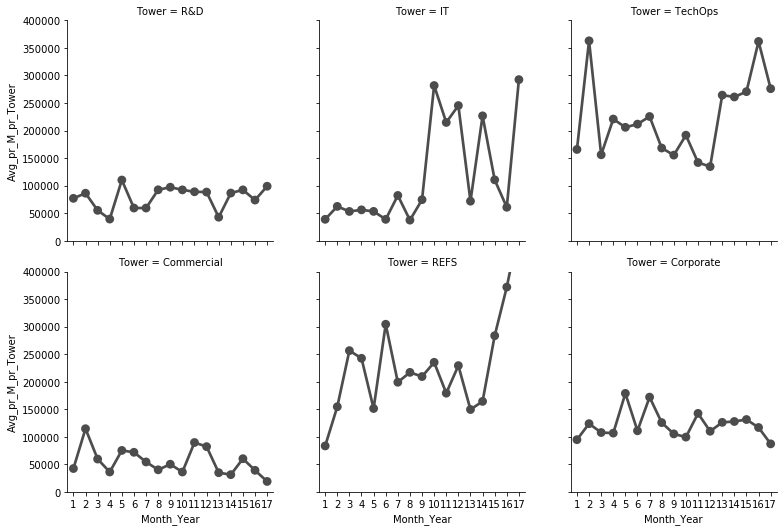

In [470]:
g = sns.FacetGrid(df, col="Tower", col_wrap=3, height=3.75, ylim=(0, 400000))
g = g.map(sns.pointplot, "Month_Year", "Avg_pr_M_pr_Tower", color=".3")
g.set_xticklabels(labels=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17])

##### Region
y_axis = average value of spending per month for each catagorie of Tower

x_axis = month (time)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

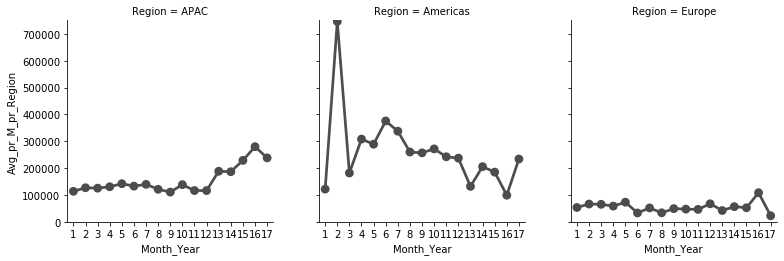

In [387]:
g = sns.FacetGrid(df, col="Region", col_wrap=3, height=3.75, ylim=(0, 750000))
g = g.map(sns.pointplot, "Month_Year", "Avg_pr_M_pr_Region", color=".3")
g.set_xticklabels(labels=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17])

##### Catagory

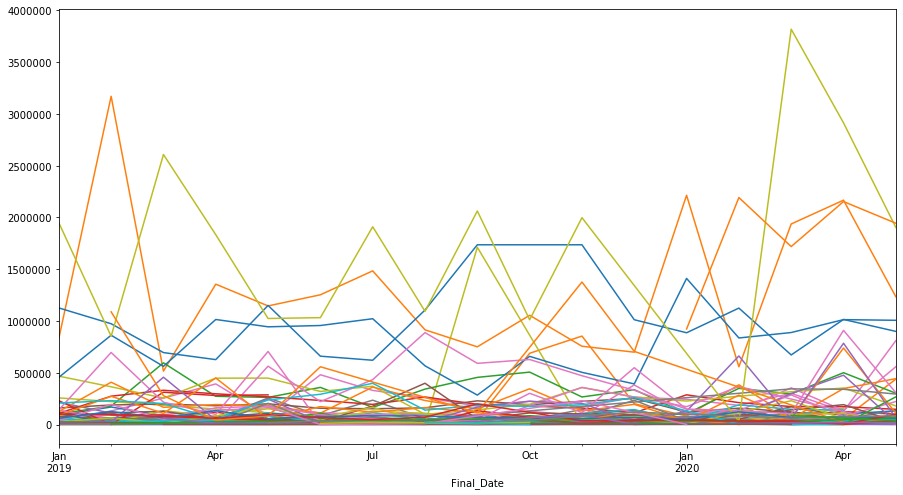

In [462]:
catagories = df.Category.unique()

for catagorie in catagories:
    df1 = df[df['Category'] == catagorie]['Avg_pr_M_pr_Category']
    df_cat0 = df1.groupby('Final_Date').mean()
    df_cat0.plot(figsize=(15,8))

##### Country

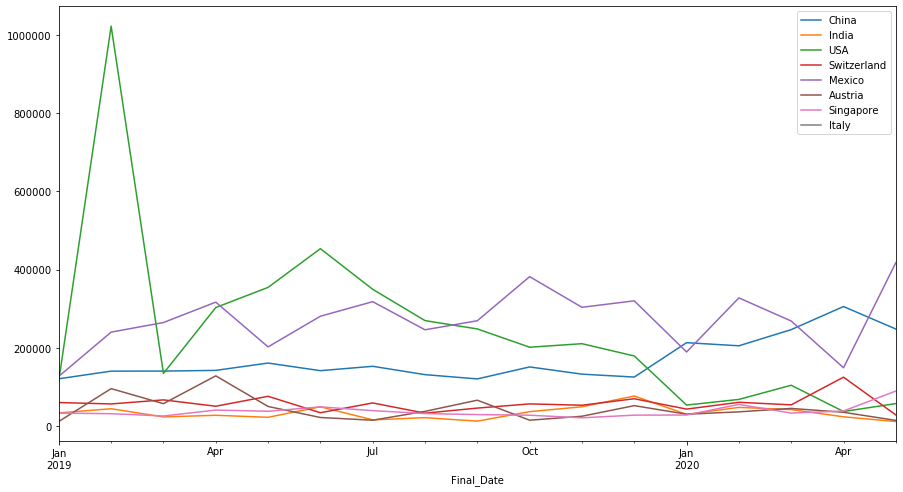

In [460]:
countries = df.Country.unique()

for country in countries:
    df1 = df[df['Country'] == country]['Avg_pr_M_pr_Country']
    df_cat0 = df1.groupby('Final_Date').mean()
    df_cat0.plot(figsize=(15,8)).legend(countries)

##### Conclusion:

From above plots, there are few common insights.
1. No. of data points are only 17 (if we consider average monthly values), which is less for time series
2. Lack of a clear upward/downward trend.
3. Interdependencies of variable which effects spend. These interdepencies will be difficult to capture using timeseries.

#### Understanding the impact of catagorical variable on target

In [599]:
def plot_categories2(df, var):
    
    fig, ax = plt.subplots(figsize=(8, 4))
    plt.xticks(df.index, df[var], rotation=90)

    ax2 = ax.twinx()
    ax.bar(df.index, df["perc_data"], color='lightgrey')
    ax2.plot(df.index, df["Spend"], color='green', label='Seconds')
    ax.set_ylabel('percentage of spending per feature')
    ax.set_xlabel(var)
    ax2.set_ylabel('Average spending per feature')
    plt.show()

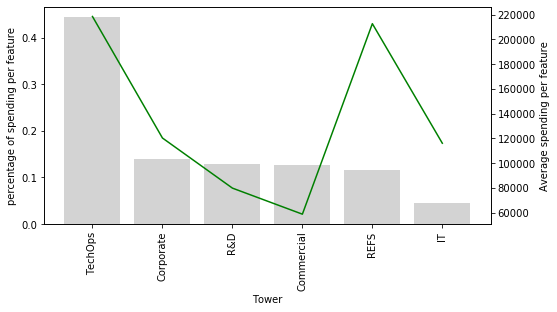

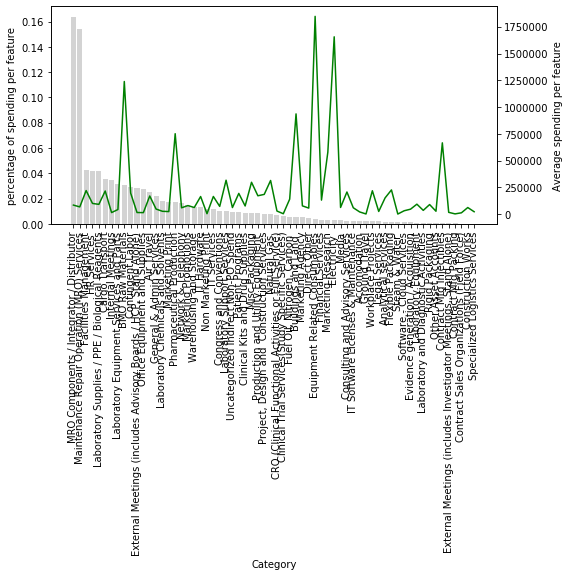

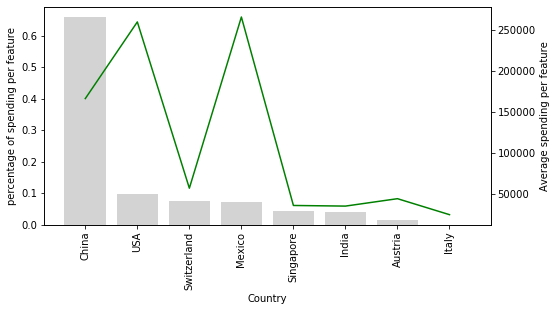

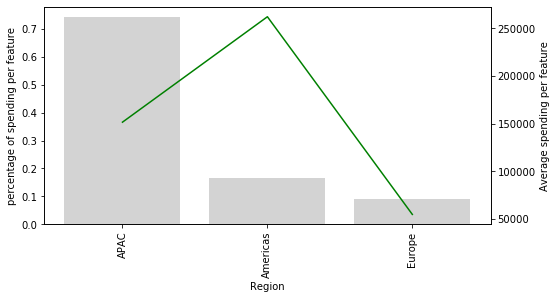

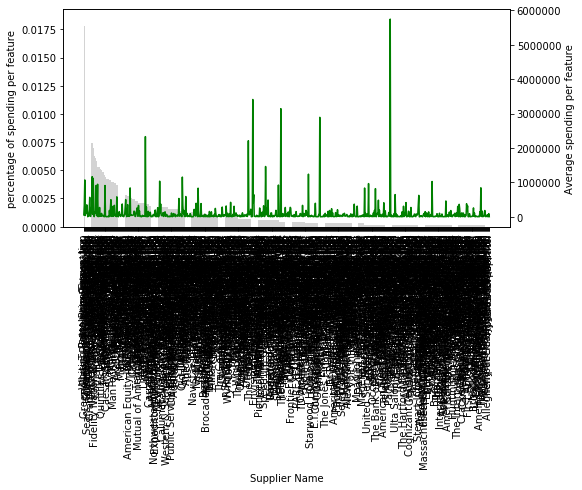

In [600]:
for var in ['Tower','Category','Country','Region','Supplier Name']:
    temp_df = calculate_mean_target_per_category(df, var)
    plot_categories2(temp_df, var)

#### Studying the variables for Machine Learning Model

##### Missing data

In [473]:
df.isnull().sum()

Supplier Name           0
Region                  0
Country                 0
Tower                   0
Category                0
Spend                   0
Avg_pr_M                0
Avg_pr_M_pr_Tower       0
Avg_pr_M_pr_Category    0
Avg_pr_M_pr_Country     0
Avg_pr_M_pr_Region      0
Avg_pr_M_pr_Vendor      0
Scaled_Tower            0
Scaled_Catagory         0
Scaled_Country          0
Scaled_Region           0
Scaled_Vendor           0
dtype: int64

##### Cardinality

High cardinality leads to uneven distribution of categories in train and test sets

In [474]:
obj_df = df.select_dtypes(include=['object']).copy()

for column in obj_df.columns:
    print('Feature: {} has Cardinality Value: {}'. format(column, len(df[column].unique())))
    #print(df[column].unique())
    print()

Feature: Supplier Name has Cardinality Value: 824

Feature: Region has Cardinality Value: 3

Feature: Country has Cardinality Value: 8

Feature: Tower has Cardinality Value: 6

Feature: Category has Cardinality Value: 64



##### Rare Label



Rare values may cause overfitting in tree based algo

###### Initial Study

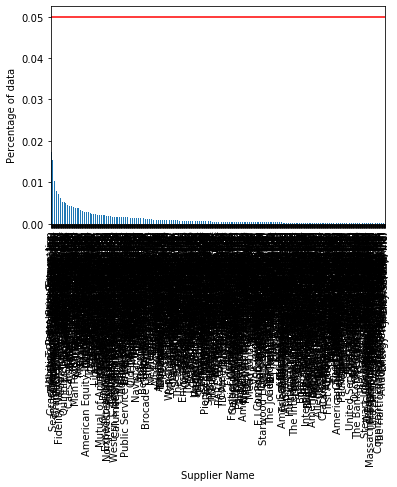

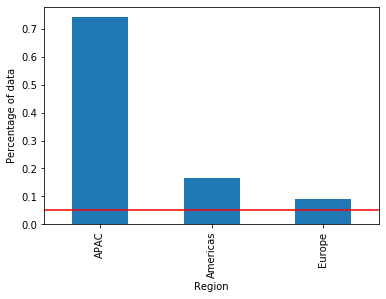

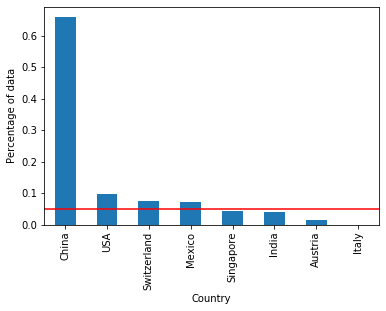

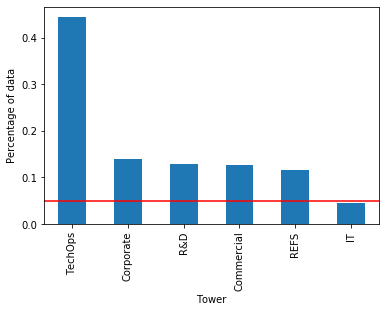

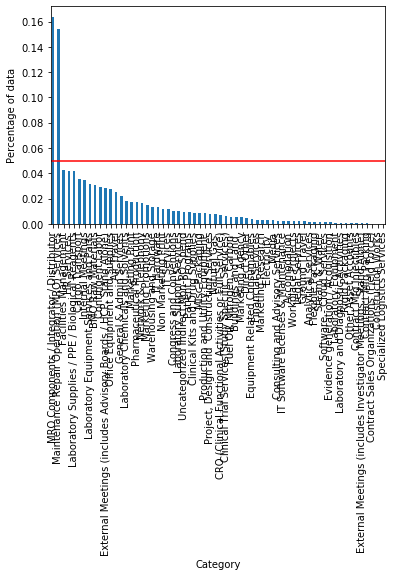

In [475]:
total = len(df)

# for each categorical variable
for col in obj_df:
    temp_df = pd.Series(df[col].value_counts() / total)

    fig = temp_df.sort_values(ascending=False).plot.bar()
    fig.set_xlabel(col)

    # add a line at 5 % to flag the threshold for rare categories
    fig.axhline(y=0.05, color='red')
    fig.set_ylabel('Percentage of data')
    plt.show()

###### Tower

In [482]:
def calculate_mean_target_per_category(df, var):

    total = len(df)

    temp_df = pd.Series(df[var].value_counts() / total).reset_index()
    temp_df.columns = [var, 'perc_data']

    temp_df = temp_df.merge(df.groupby([var])['Spend'].mean().reset_index(),
                            on=var,
                            how='left')

    return temp_df

In [483]:
temp_df = calculate_mean_target_per_category(df, 'Tower')
temp_df

,Tower,perc_data,Spend
0,TechOps,0.444128,218415.095122
1,Corporate,0.140214,120215.205952
2,R&D,0.128114,79726.473288
3,Commercial,0.126833,58675.202902
4,REFS,0.115160,212603.532015
5,IT,0.045552,116005.586182


In [484]:
def plot_categories(df, var):
    
    fig, ax = plt.subplots(figsize=(8, 4))
    plt.xticks(df.index, df[var], rotation=90)

    ax2 = ax.twinx()
    ax.bar(df.index, df["perc_data"], color='lightgrey')
    ax2.plot(df.index, df["Spend"], color='green', label='Seconds')
    ax.axhline(y=0.05, color='red')
    ax.set_ylabel('percentage of spending per feature')
    ax.set_xlabel(var)
    ax2.set_ylabel('Average spending per feature')
    plt.show()

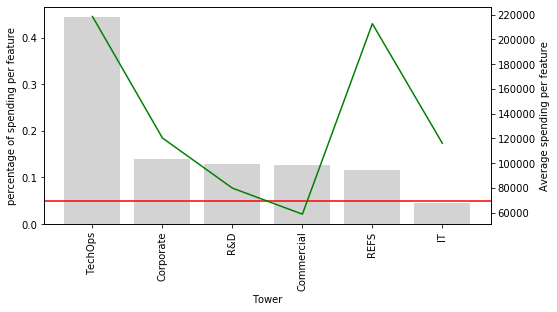

In [485]:
plot_categories(temp_df, 'Tower')

###### Catagory

This analysis is important because the catagories which are rare has higher spending, that means that they are important but we don't have enough data so that model will learn it properly.

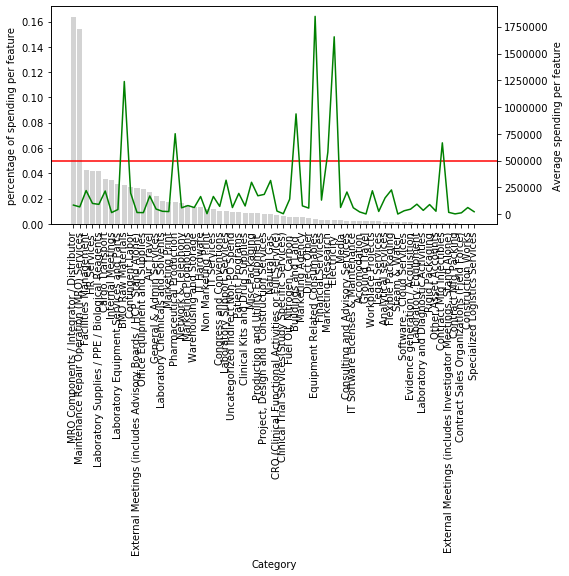

In [486]:
temp_df = calculate_mean_target_per_category(df, 'Category')
plot_categories(temp_df, 'Category')

###### Country

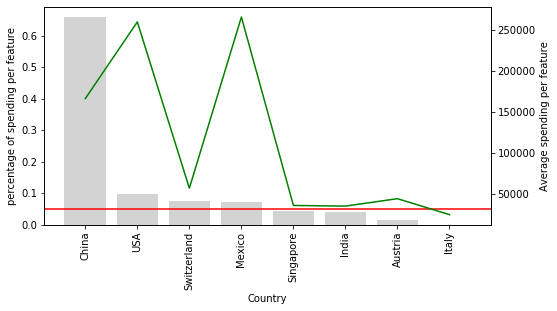

In [487]:
temp_df = calculate_mean_target_per_category(df, 'Country')
plot_categories(temp_df, 'Country')

###### Supplier Name

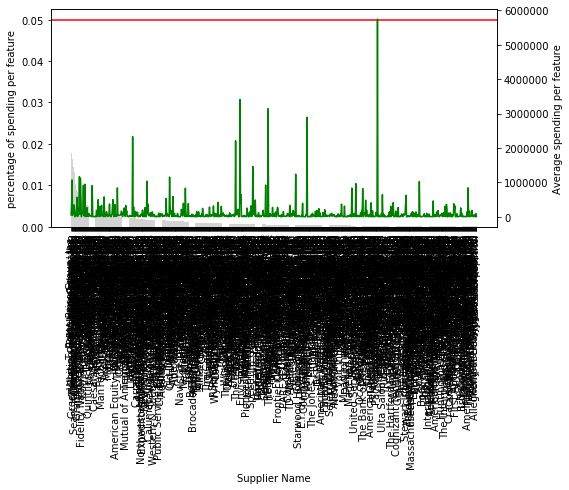

In [488]:
temp_df = calculate_mean_target_per_category(df, 'Supplier Name')
plot_categories(temp_df, 'Supplier Name')

##### Linear Relationship



In this section we are study the linear relationship of target with other features which were created. Our conclusion from this is even after variable log transformation, linear relationship is not good. 

###### linear plot

<IPython.core.display.Javascript object>

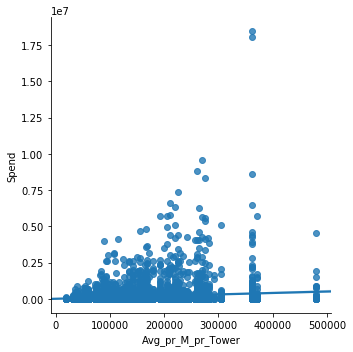

In [490]:
sns.lmplot(x="Avg_pr_M_pr_Tower", y="Spend", data=df, order=1)

<IPython.core.display.Javascript object>

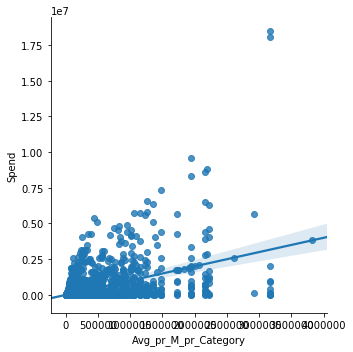

In [491]:
sns.lmplot(x="Avg_pr_M_pr_Category", y="Spend", data=df, order=1)

<IPython.core.display.Javascript object>

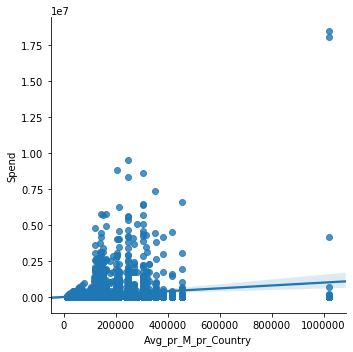

In [492]:
sns.lmplot(x="Avg_pr_M_pr_Country", y="Spend", data=df, order=1)

<IPython.core.display.Javascript object>

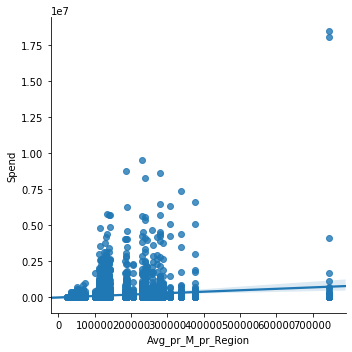

In [493]:
sns.lmplot(x="Avg_pr_M_pr_Region", y="Spend", data=df, order=1)

<IPython.core.display.Javascript object>

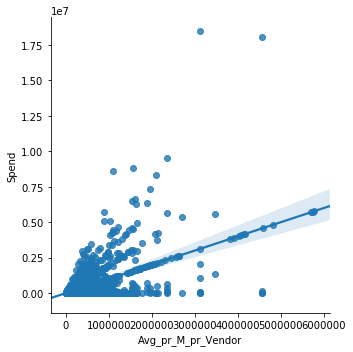

In [494]:
sns.lmplot(x="Avg_pr_M_pr_Vendor", y="Spend", data=df, order=1)

###### Linear plot after log transformation

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

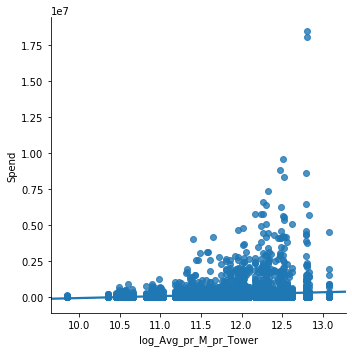

In [501]:
df['log_Avg_pr_M_pr_Tower'] = np.log(df['Avg_pr_M_pr_Tower'])
sns.lmplot(x="log_Avg_pr_M_pr_Tower", y="Spend", data=df, order=1)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

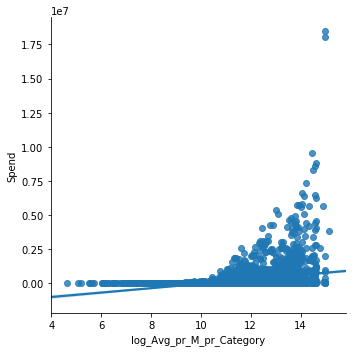

In [502]:
df['log_Avg_pr_M_pr_Category'] = np.log(df['Avg_pr_M_pr_Category'])
sns.lmplot(x="log_Avg_pr_M_pr_Category", y="Spend", data=df, order=1)

###### Correlation Plot

<IPython.core.display.Javascript object>

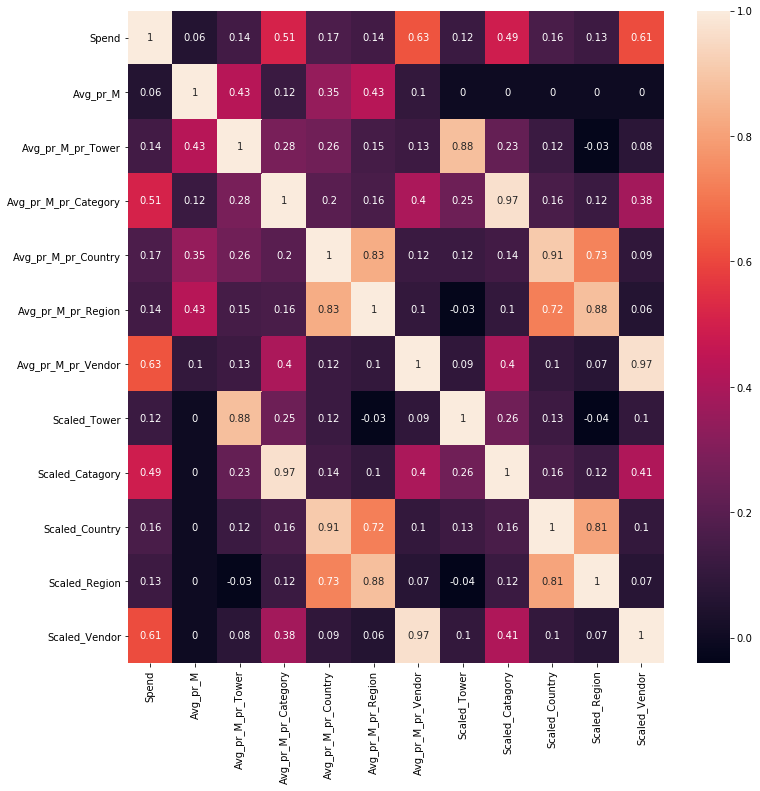

In [495]:
Cont_df = df.select_dtypes(include=['int64', 'float']).copy()

correlation_matrix = Cont_df.corr().round(2)

figure = plt.figure(figsize=(12, 12))
sns.heatmap(data=correlation_matrix, annot=True)

<IPython.core.display.Javascript object>

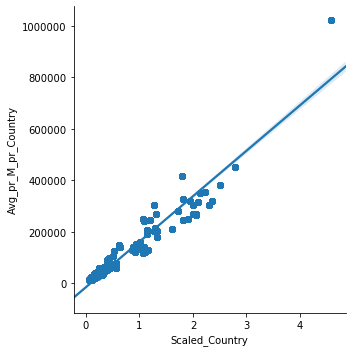

In [500]:
sns.lmplot(x="Scaled_Country", y="Avg_pr_M_pr_Country", data=df, order=1)

<IPython.core.display.Javascript object>

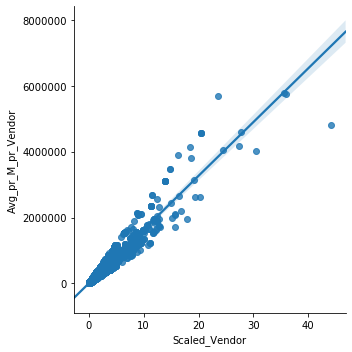

In [499]:
sns.lmplot(x="Scaled_Vendor", y="Avg_pr_M_pr_Vendor", data=df, order=1)

<IPython.core.display.Javascript object>

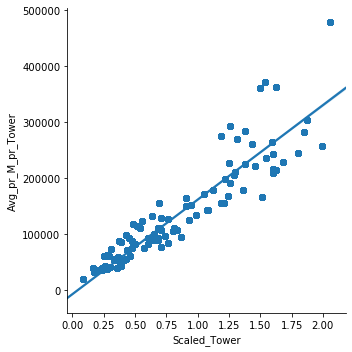

In [497]:
sns.lmplot(x="Scaled_Tower", y="Avg_pr_M_pr_Tower", data=df, order=1)

<IPython.core.display.Javascript object>

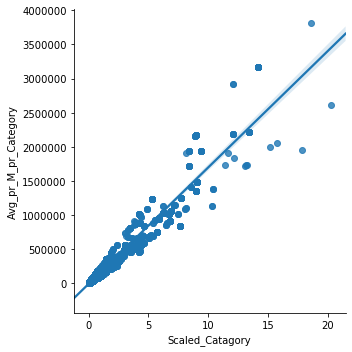

In [498]:
sns.lmplot(x="Scaled_Catagory", y="Avg_pr_M_pr_Category", data=df, order=1)

So our beleif of creating new scaled feature which could be used as additional feature to capture some amount of information can not be used as they have high correlation with their average values. We need to remove them.

##### Outlier

We study the presense of outlier using interquantile proximity rule

###### Plotting Histogram, QQ Plot and Box plot

In [631]:
import scipy.stats as stats

def diagnostic_plots(df, variable):

    # define figure size
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.distplot(df[variable], bins=30)
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('RM quantiles')

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

The feature is Avg_pr_M:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

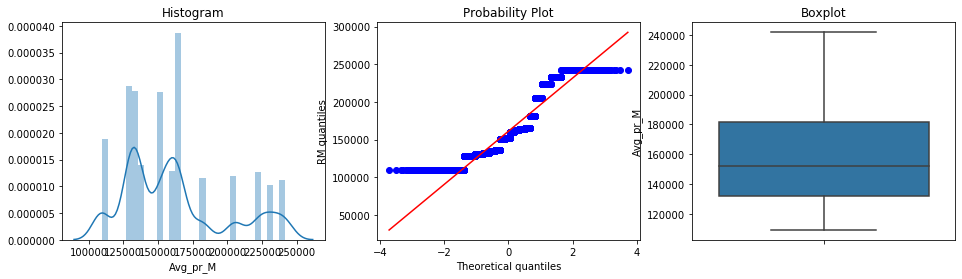

The feature is Avg_pr_M_pr_Tower:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

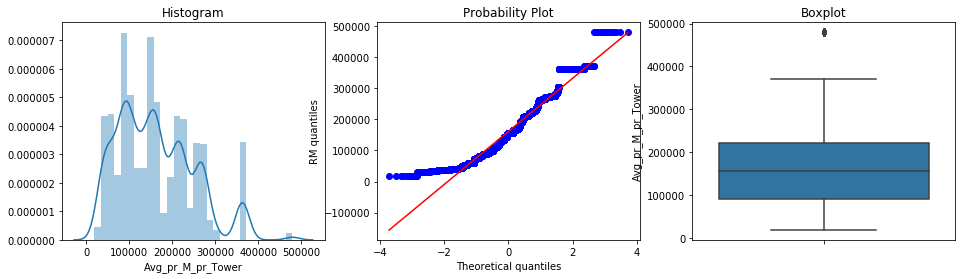

The feature is Avg_pr_M_pr_Category:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

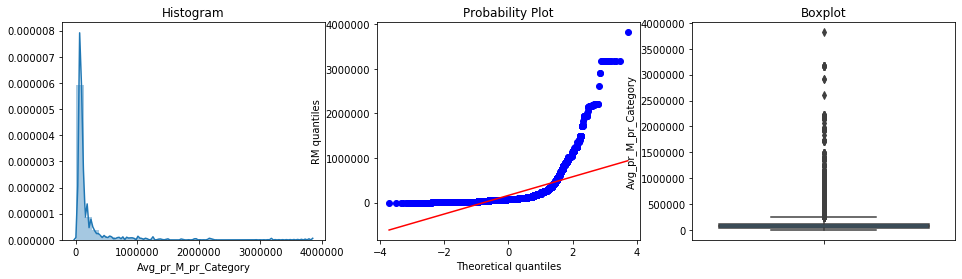

The feature is Avg_pr_M_pr_Country:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

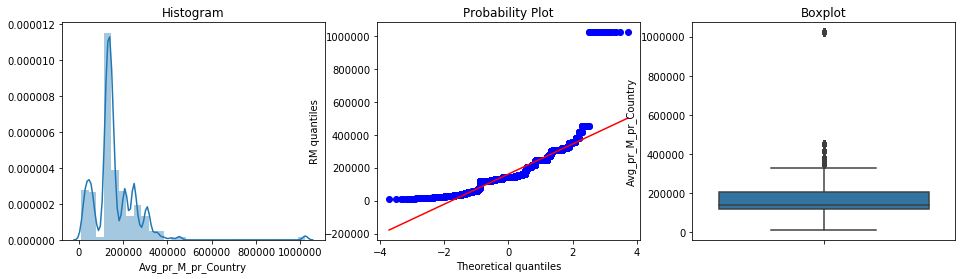

The feature is Avg_pr_M_pr_Region:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

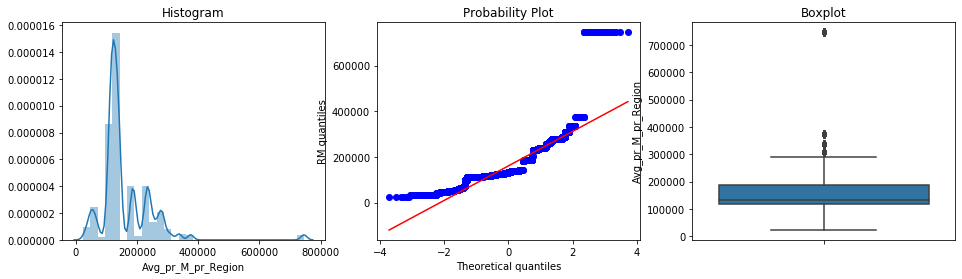

The feature is Avg_pr_M_pr_Vendor:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

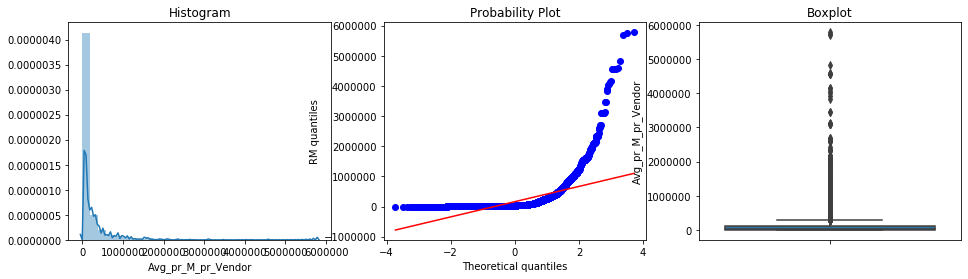

The feature is Spend:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

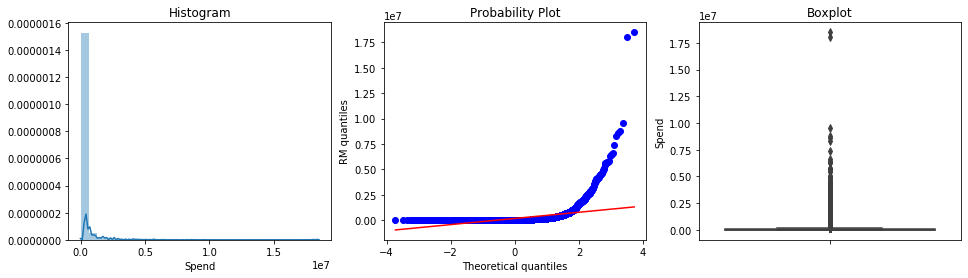

In [510]:
for column in ['Avg_pr_M', 'Avg_pr_M_pr_Tower', 'Avg_pr_M_pr_Category','Avg_pr_M_pr_Country', 
                'Avg_pr_M_pr_Region', 'Avg_pr_M_pr_Vendor', 'Spend']:
    print('The feature is {}:'.format(column))
    diagnostic_plots(df, column)

###### Outlier detection for skewed variables

In [511]:
# function to find upper and lower boundaries
# for skewed distributed variables

def find_skewed_boundaries(df, variable, distance):

    # Calculating the boundaries outside which sit the outliers
    # for skewed distributions

    # distance passed as an argument, gives us the option to
    # estimate 1.5 times or 3 times the IQR to calculate
    # the boundaries.

    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)

    return upper_boundary, lower_boundary

In [530]:
# looking for outliers,
# using the interquantile proximity rule
# IQR * 1.5, the standard metric

print('total data: {}'.format(len(df)))
print()
for feature in ['Avg_pr_M_pr_Category','Avg_pr_M_pr_Vendor','Spend', 'Avg_pr_M_pr_Region','Avg_pr_M_pr_Tower']:
    upper_boundary, lower_boundary = find_skewed_boundaries(df, feature, 1.5)
    print('{}: upper limit & {}: lower limit'.format(upper_boundary, lower_boundary) )
    
    print('data with value bigger than {}: {}'.format(upper_boundary, len(df[df[feature] > upper_boundary])))
    print('% data with value bigger than {}: {}'.format(upper_boundary, len(df[df[feature] > upper_boundary])/len(df)))
    print()                                                                      

total data: 7025

246017.3723207988: upper limit & -76290.58196415287: lower limit
data with value bigger than 246017.3723207988: 943
% data with value bigger than 246017.3723207988: 0.13423487544483986

300707.51928516: upper limit & -168127.20233244: lower limit
data with value bigger than 300707.51928516: 1007
% data with value bigger than 300707.51928516: 0.14334519572953736

179111.98187532002: upper limit & -100340.69640660001: lower limit
data with value bigger than 179111.98187532002: 1042
% data with value bigger than 179111.98187532002: 0.14832740213523132

296109.1579575251: upper limit & 8924.874981761226: lower limit
data with value bigger than 296109.1579575251: 273
% data with value bigger than 296109.1579575251: 0.038861209964412814

413732.07774968795: upper limit & -100695.63139588707: lower limit
data with value bigger than 413732.07774968795: 26
% data with value bigger than 413732.07774968795: 0.003701067615658363



##### Feature Scaling

We are planning to go ahead with tree based algorithm, hence feature scalling is not important.

### Preparing Data For ML Models

In [646]:
df.drop(['Year', 'Month', 'Month_Year'], inplace=True,axis=1)

In [647]:
df.head(2)

,Supplier Name,Region,Country,Tower,Category,Spend,Avg_pr_M,Avg_pr_M_pr_Tower,Avg_pr_M_pr_Category,Avg_pr_M_pr_Country,Avg_pr_M_pr_Region,Avg_pr_M_pr_Vendor,Scaled_Tower,Scaled_Catagory,Scaled_Country,Scaled_Region,Scaled_Vendor
Final_Date,,,,,,,,,,,,,,,,,
2019-01,"AptarGroup, Inc.",APAC,China,R&D,Laboratory Equipment Services and Parts,964537.590650,109290.666602,76869.416233,119281.653576,121275.831388,113822.506881,964537.59065,0.703348,1.091417,1.109663,1.041466,8.825434
2019-01,UnitedHealth Group,APAC,India,IT,IT Hardware,1609.153631,109290.666602,38833.989011,1886.232363,34003.078873,113822.506881,1409.83589,0.355328,0.017259,0.311125,1.041466,0.012900


### Feature Engineering

#### Variable Transformation

In [535]:
def diagnostic_plots(df, variable):
    
    # function to plot a histogram and a Q-Q plot
    # side by side, for a certain variable
    
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    df[variable].hist()

    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)

    plt.show()

In [546]:
# Transforming Variable

lt1 = vt.BoxCoxTransformer(variables = ['Avg_pr_M','Avg_pr_M_pr_Tower','Avg_pr_M_pr_Category','Avg_pr_M_pr_Country','Avg_pr_M_pr_Region','Avg_pr_M_pr_Vendor'])
lt1.fit(df)
data_tf1 = lt1.transform(df)

lt2 = vt.YeoJohnsonTransformer(variables = ['Avg_pr_M','Avg_pr_M_pr_Tower','Avg_pr_M_pr_Category','Avg_pr_M_pr_Country','Avg_pr_M_pr_Region','Avg_pr_M_pr_Vendor'])
lt2.fit(df)
data_tf2 = lt2.transform(df)

C:\Users\saurabhkumar9\AppData\Local\Continuum\anaconda2\envs\spyder\lib\site-packages\scipy\stats\morestats.py:1478: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(trans.var(axis=0))
C:\Users\saurabhkumar9\AppData\Local\Continuum\anaconda2\envs\spyder\lib\site-packages\scipy\optimize\optimize.py:1986: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
C:\Users\saurabhkumar9\AppData\Local\Continuum\anaconda2\envs\spyder\lib\site-packages\scipy\optimize\optimize.py:1987: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = 2.0 * (tmp2 - tmp1)
C:\Users\saurabhkumar9\AppData\Local\Continuum\anaconda2\envs\spyder\lib\site-packages\scipy\optimize\optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
C:\Users\saurabhkumar9\AppData\Local\Continuum\anaconda2\envs\spyder\lib\site-packages\scipy\optimize\optimize.py:1984: RuntimeWarning: inval

Plot for Avg_pr_M


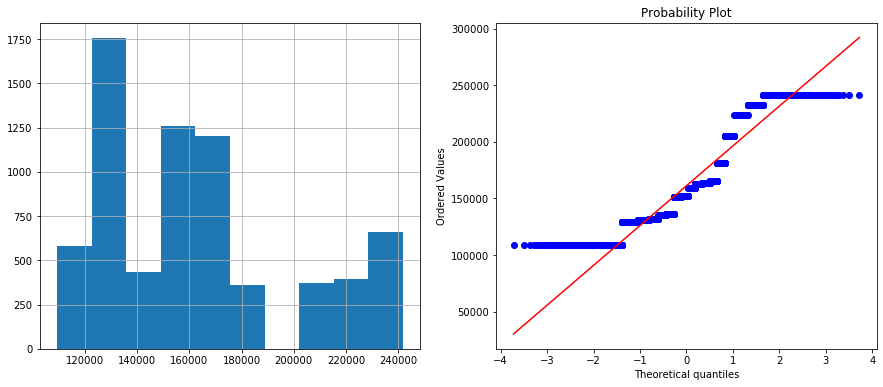

BoxCox Transformed Plot for Avg_pr_M


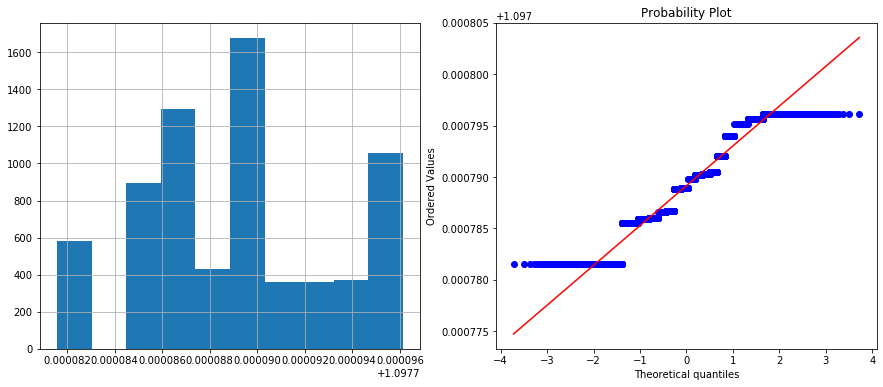

Yeo Johnson Transformed Plot for Avg_pr_M


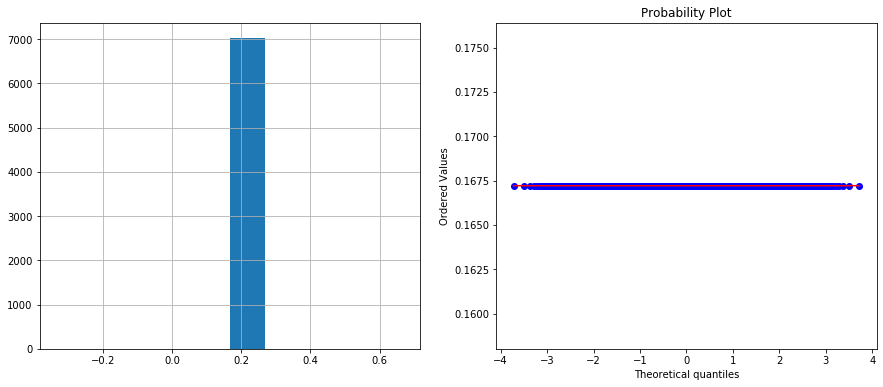

Plot for Avg_pr_M_pr_Tower


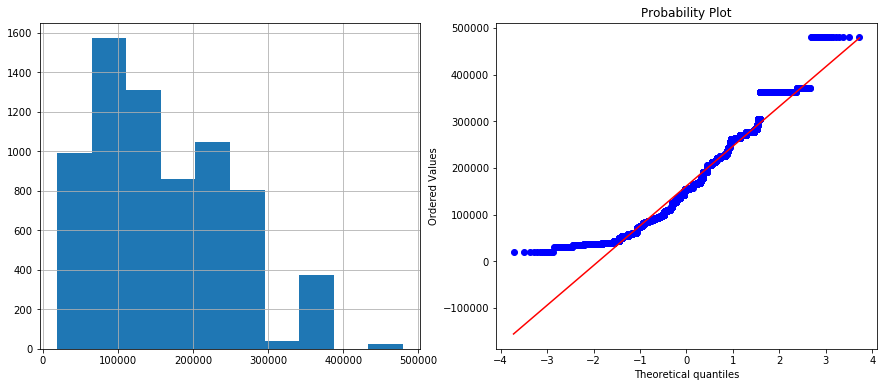

BoxCox Transformed Plot for Avg_pr_M_pr_Tower


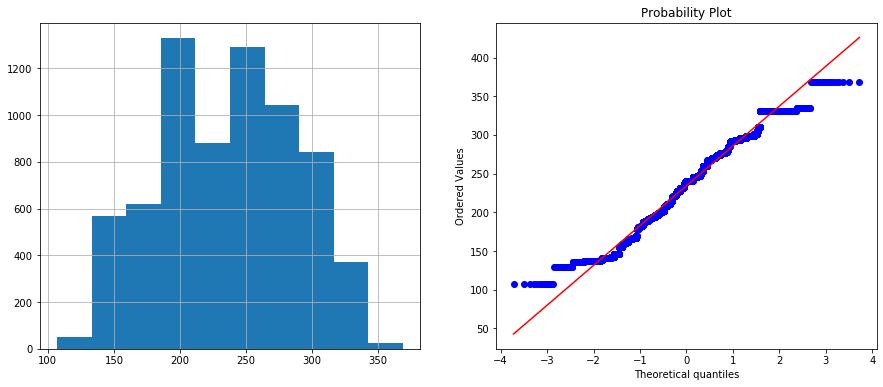

Yeo Johnson Transformed Plot for Avg_pr_M_pr_Tower


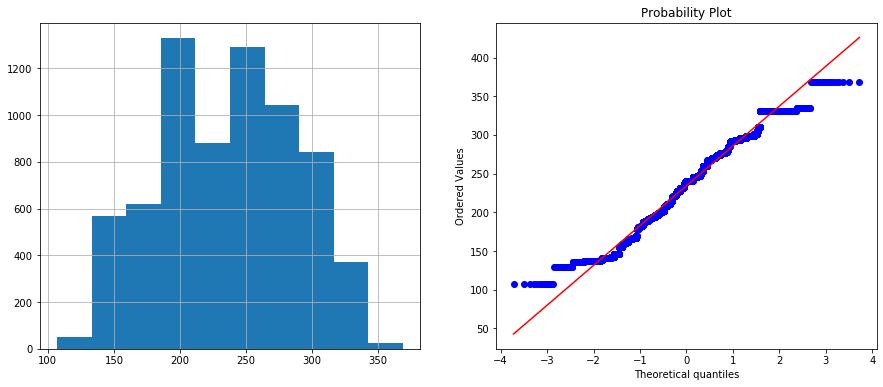

Plot for Avg_pr_M_pr_Category


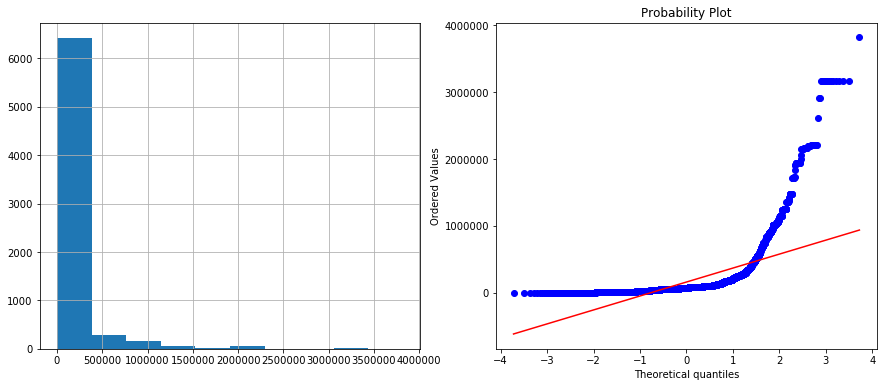

BoxCox Transformed Plot for Avg_pr_M_pr_Category


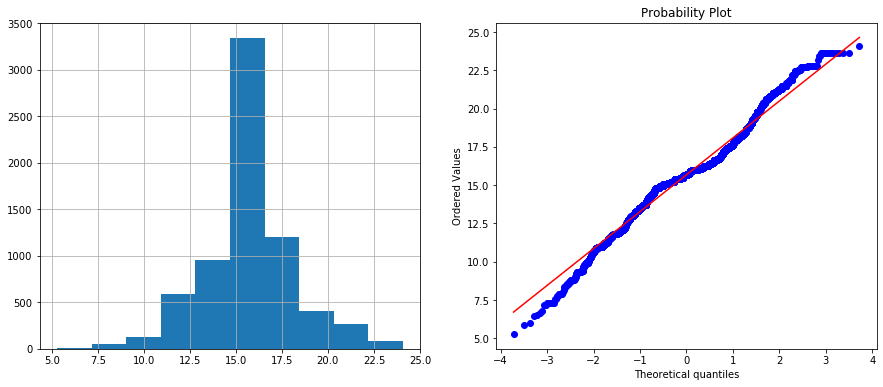

Yeo Johnson Transformed Plot for Avg_pr_M_pr_Category


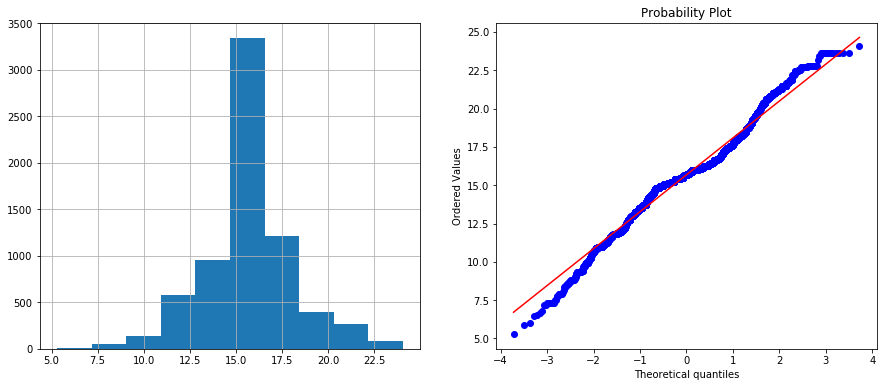

Plot for Avg_pr_M_pr_Country


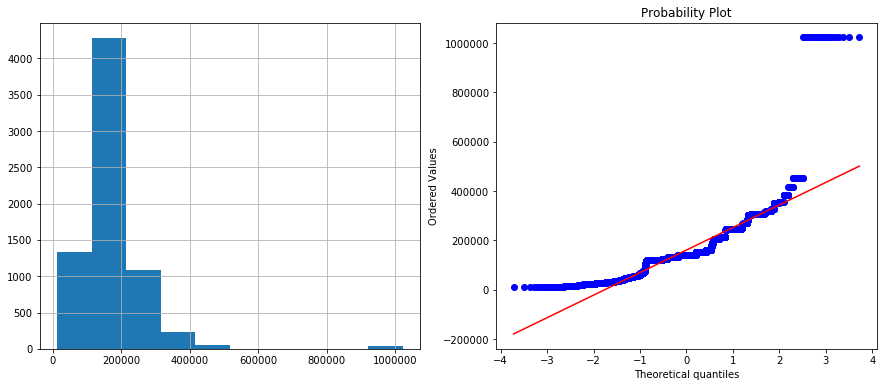

BoxCox Transformed Plot for Avg_pr_M_pr_Country


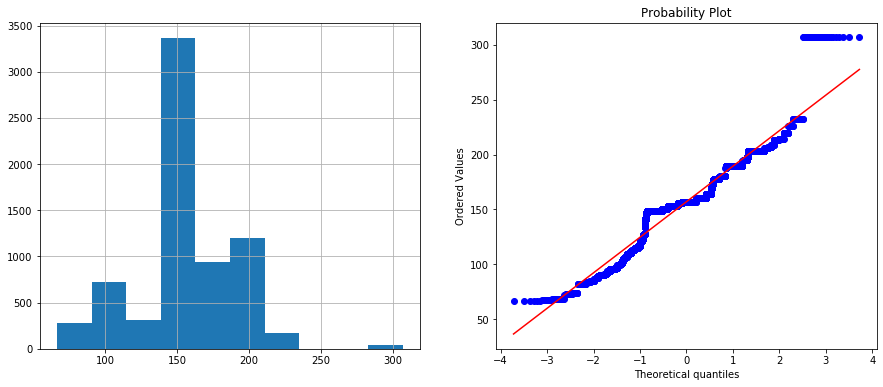

Yeo Johnson Transformed Plot for Avg_pr_M_pr_Country


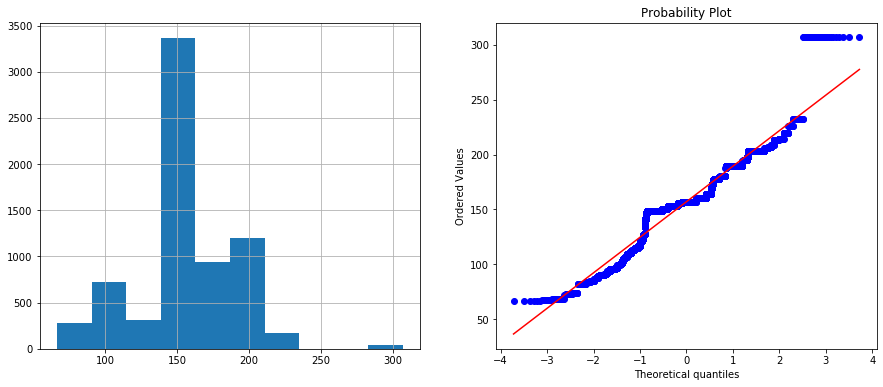

Plot for Avg_pr_M_pr_Region


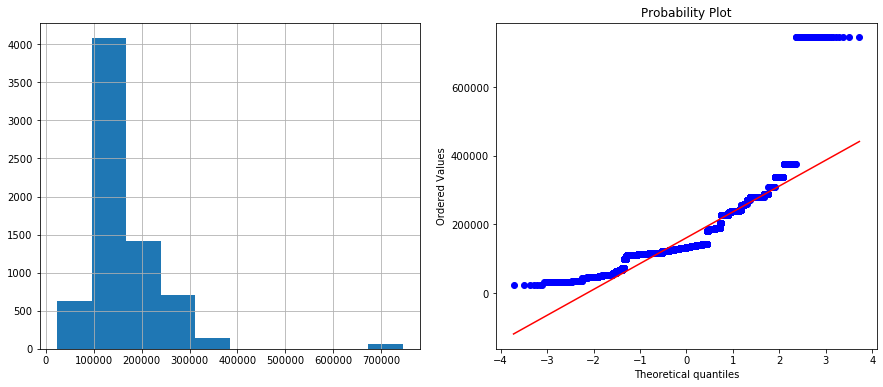

BoxCox Transformed Plot for Avg_pr_M_pr_Region


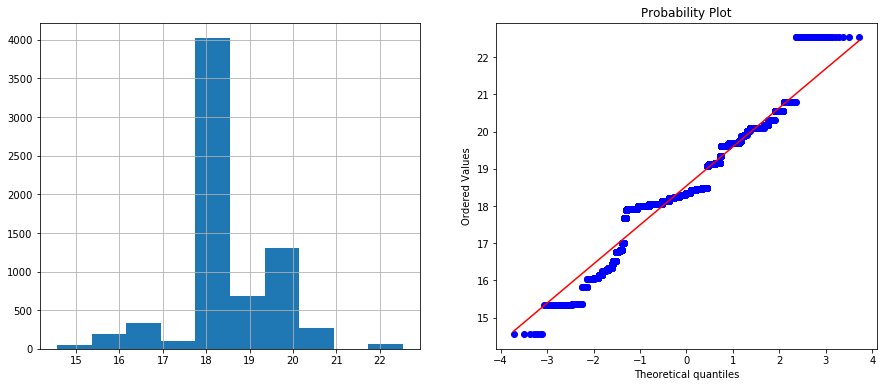

Yeo Johnson Transformed Plot for Avg_pr_M_pr_Region


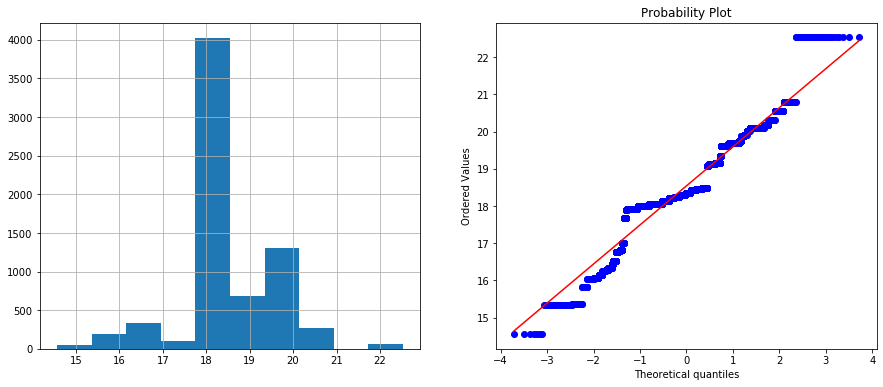

Plot for Avg_pr_M_pr_Vendor


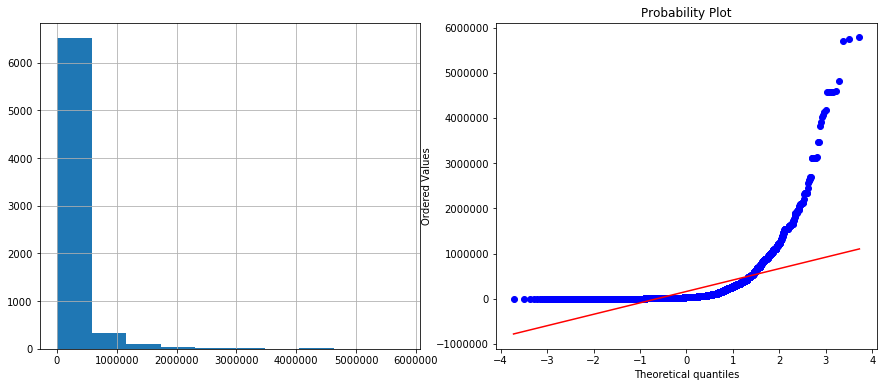

BoxCox Transformed Plot for Avg_pr_M_pr_Vendor


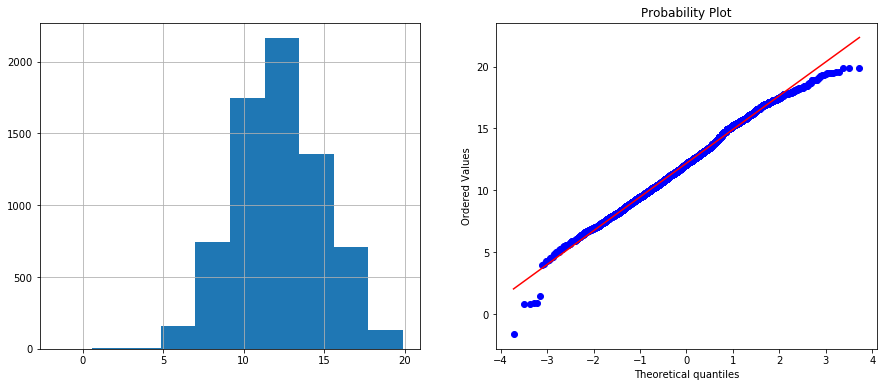

Yeo Johnson Transformed Plot for Avg_pr_M_pr_Vendor


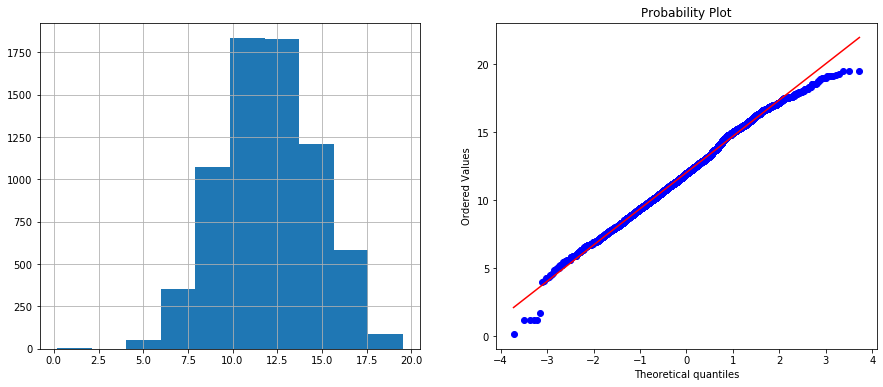

In [550]:
# plotting
for variable in ['Avg_pr_M', 'Avg_pr_M_pr_Tower', 'Avg_pr_M_pr_Category','Avg_pr_M_pr_Country', 
                 'Avg_pr_M_pr_Region', 'Avg_pr_M_pr_Vendor']:
    print('Plot for {}'.format(variable))
    diagnostic_plots(df, variable)
    print('BoxCox Transformed Plot for {}'.format(variable))
    diagnostic_plots(data_tf1, variable)
    print('Yeo Johnson Transformed Plot for {}'.format(variable))
    diagnostic_plots(data_tf2, variable)

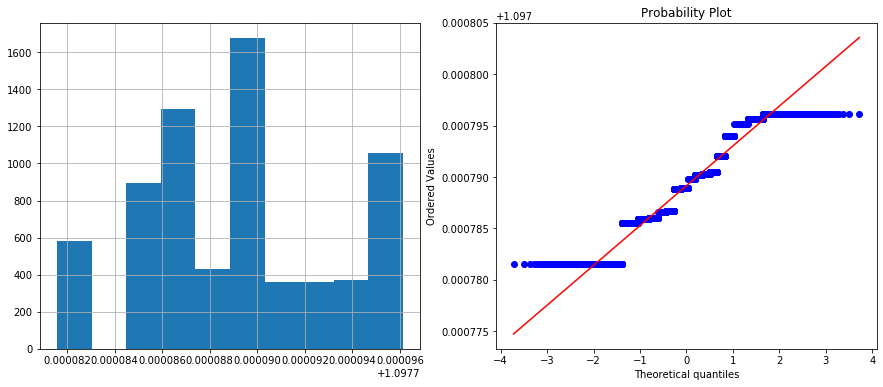

In [543]:
diagnostic_plots(data_tf, 'Avg_pr_M')

#### Discretization

###### Performing Equal Frequency Discretization

Discretisation is the process of transforming continuous variables into discrete variables by creating a set of contiguous intervals that span the range of the variable's values.

Discretisation helps handle outliers and may improve value spread in skewed variables.

Equal frequency discretisation divides the scope of possible values of the variable into N bins, where each bin carries the same amount of observations. This is a Unsupervised discretisation methods.

In [566]:
variable = ['Scaled_Tower','Scaled_Catagory','Scaled_Country', 'Scaled_Region','Scaled_Vendor']

X_train, X_test, y_train, y_test = train_test_split(df[variable], df['Spend'],
                                                    test_size=0.3, random_state=0)

X_train.shape, X_test.shape

<IPython.core.display.Javascript object>

((4917, 5), (2108, 5))

In [570]:
disc = EqualFrequencyDiscretiser(q=10, variables=variable, return_object=True)

# find the intervals
disc.fit(X_train)

# transform train and text
train_t = disc.transform(X_train)
test_t = disc.transform(X_test)

In [571]:
train_t.dtypes

Scaled_Tower       object
Scaled_Catagory    object
Scaled_Country     object
Scaled_Region      object
Scaled_Vendor      object
dtype: object

###### Exploring if the bins have a linear relationship with target

Text(0, 0.5, 'mean of Scaled_Tower')

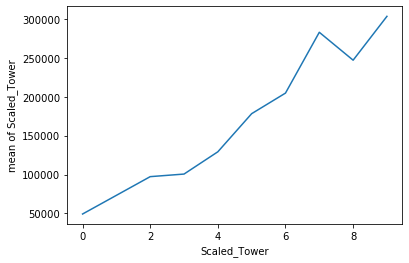

In [580]:
pd.concat([train_t, y_train], axis=1).groupby('Scaled_Tower')['Spend'].mean().plot()
plt.ylabel('mean of Scaled_Tower')

Text(0, 0.5, 'mean of Scaled_Catagory')

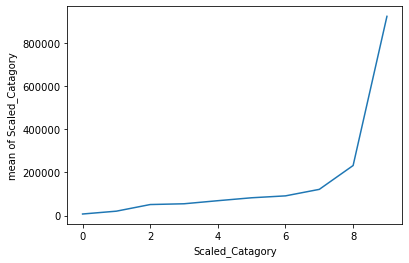

In [581]:
pd.concat([train_t, y_train], axis=1).groupby('Scaled_Catagory')['Spend'].mean().plot()
plt.ylabel('mean of Scaled_Catagory')

Text(0, 0.5, 'mean of Scaled_Country')

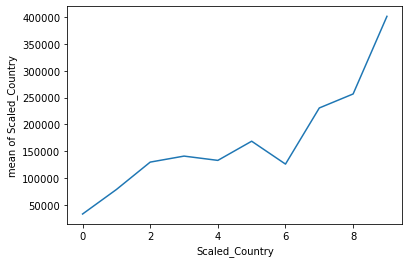

In [582]:
pd.concat([train_t, y_train], axis=1).groupby('Scaled_Country')['Spend'].mean().plot()
plt.ylabel('mean of Scaled_Country')

Text(0, 0.5, 'mean of Scaled_Region')

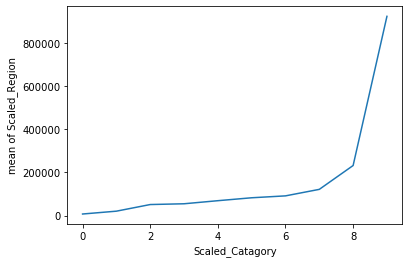

In [583]:
pd.concat([train_t, y_train], axis=1).groupby('Scaled_Catagory')['Spend'].mean().plot()
plt.ylabel('mean of Scaled_Category')

Text(0, 0.5, 'mean of Scaled_Vendor')

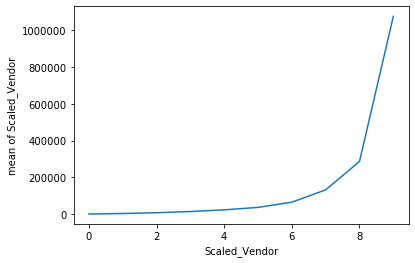

In [584]:
pd.concat([train_t, y_train], axis=1).groupby('Scaled_Vendor')['Spend'].mean().plot()
plt.ylabel('mean of Scaled_Vendor')

The variables don't show a clear linear relationship with target variable after discretization. One way to solve this is by encoding.

###### Ordinal Encoding to establish linear relationship with target

In [587]:
enc = OrdinalCategoricalEncoder(encoding_method = 'ordered')

enc.fit(train_t, y_train)

train_t = enc.transform(train_t)
test_t = enc.transform(test_t)

In [588]:
enc.encoder_dict_

{'Scaled_Tower': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 8: 7, 7: 8, 9: 9},
 'Scaled_Catagory': {0: 0,
  1: 1,
  2: 2,
  3: 3,
  4: 4,
  5: 5,
  6: 6,
  7: 7,
  8: 8,
  9: 9},
 'Scaled_Country': {0: 0,
  1: 1,
  6: 2,
  2: 3,
  4: 4,
  3: 5,
  5: 6,
  7: 7,
  8: 8,
  9: 9},
 'Scaled_Region': {0: 0, 3: 1, 1: 2, 4: 3, 2: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9},
 'Scaled_Vendor': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9}}

Text(0, 0.5, 'mean of Scaled_Tower')

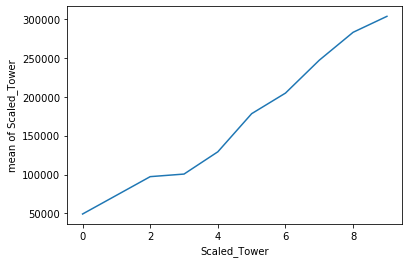

In [589]:
pd.concat([train_t, y_train], axis=1).groupby('Scaled_Tower')['Spend'].mean().plot()
plt.ylabel('mean of Scaled_Tower')

Text(0, 0.5, 'mean of Scaled_Catagory')

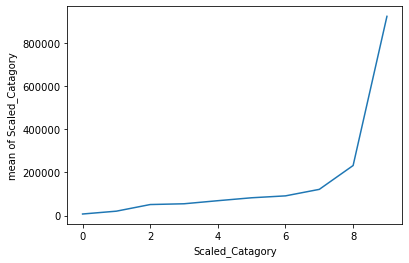

In [590]:
pd.concat([train_t, y_train], axis=1).groupby('Scaled_Catagory')['Spend'].mean().plot()
plt.ylabel('mean of Scaled_Catagory')

Text(0, 0.5, 'mean of Scaled_Country')

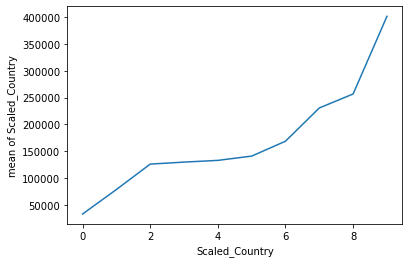

In [591]:
pd.concat([train_t, y_train], axis=1).groupby('Scaled_Country')['Spend'].mean().plot()
plt.ylabel('mean of Scaled_Country')

Text(0, 0.5, 'mean of Scaled_Category')

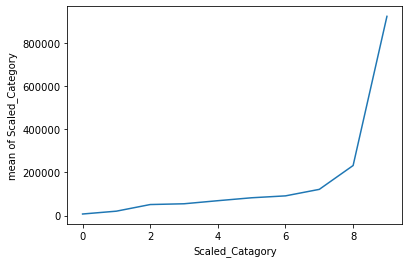

In [592]:
pd.concat([train_t, y_train], axis=1).groupby('Scaled_Catagory')['Spend'].mean().plot()
plt.ylabel('mean of Scaled_Category')

Text(0, 0.5, 'mean of Scaled_Vendor')

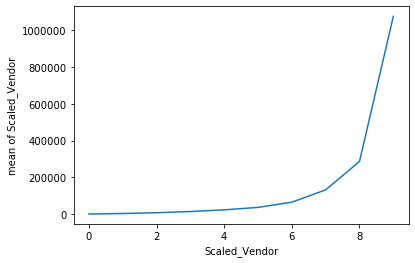

In [593]:
pd.concat([train_t, y_train], axis=1).groupby('Scaled_Vendor')['Spend'].mean().plot()
plt.ylabel('mean of Scaled_Vendor')

###### Conclusion

From above analysis we can say that, even after binning and encoding few of the variables are not having monotonic relationship with target variable. Hece we should remove them. The variable to be used after binning are:
1. Scaled_Country
2. Scaled_Tower

#### Catagorical Variable Encoding & Rare Variable Treatment

##### Rare Label Encoding

###### Rare Label Study

In [621]:
cols = ['Supplier Name', 'Region', 'Country', 'Tower', 'Category']
X_train, X_test, y_train, y_test = train_test_split(df[cols], df['Spend'],
                                                    test_size=0.3, random_state=0)

X_train.shape, X_test.shape

<IPython.core.display.Javascript object>

((4917, 5), (2108, 5))

In [622]:
for col in cols:
    print(X_train.groupby(col)[col].count() / len(X_train)) # frequency
    print()

Supplier Name
3M Company                      0.002847
A. Schulman, Inc.               0.000407
AAR Corp.                       0.001830
ABM Industries Incorporated     0.002237
AECOM Technology Corporation    0.000203
                                  ...   
Yahoo! Inc.                     0.000203
Zions Bancorporation            0.004271
eBay Inc.                       0.001017
hhgregg, Inc.                   0.000610
salesforce.com, inc.            0.000610
Name: Supplier Name, Length: 733, dtype: float64

Region
APAC        0.738052
Americas    0.171649
Europe      0.090299
Name: Region, dtype: float64

Country
Austria        0.014033
China          0.654464
India          0.039455
Italy          0.000203
Mexico         0.072198
Singapore      0.044133
Switzerland    0.076063
USA            0.099451
Name: Country, dtype: float64

Tower
Commercial    0.129754
Corporate     0.139313
IT            0.045760
R&D           0.127720
REFS          0.114094
TechOps       0.443360
Name: Towe

###### Plotting

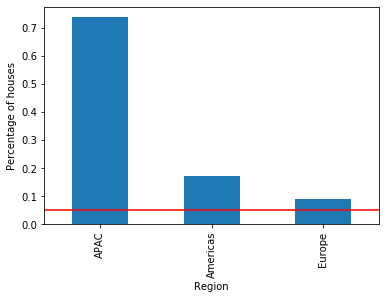

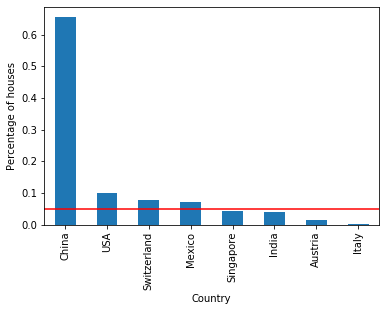

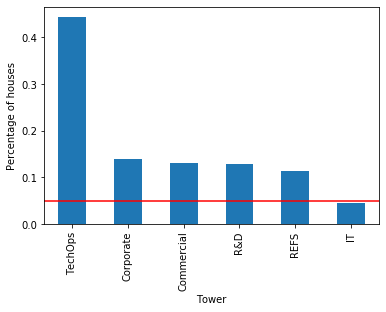

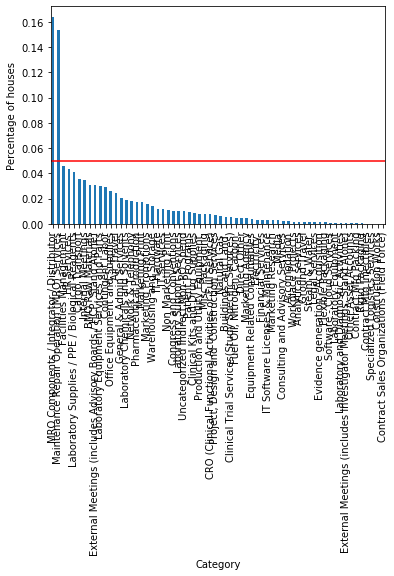

In [623]:
for col in ['Region', 'Country', 'Tower', 'Category']:

    temp_df = pd.Series(X_train[col].value_counts() / len(X_train) )

    # make plot with the above percentages
    fig = temp_df.sort_values(ascending=False).plot.bar()
    fig.set_xlabel(col)

    # add a line at 5 % to flag the threshold for rare categories
    fig.axhline(y=0.05, color='red')
    fig.set_ylabel('Percentage of houses')
    plt.show()

###### Re-grouping rare labels with pandas

In [624]:
def rare_encoding(X_train, X_test, variable, tolerance):
    X_train = X_train.copy()
    X_test = X_test.copy()

    # find the most frequent category
    frequent_cat = find_non_rare_labels(X_train, variable, tolerance)

    # re-group rare labels
    X_train[variable] = np.where(X_train[variable].isin(frequent_cat), X_train[variable], 'Rare')
    X_test[variable] = np.where(X_test[variable].isin(frequent_cat), X_test[variable], 'Rare')

    return X_train, X_test

In [625]:
for variable in ['Region', 'Country', 'Tower', 'Category']:
    X_train, X_test = rare_encoding(X_train, X_test, variable, 0.05)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

###### Plotting After Rare Label Encoding

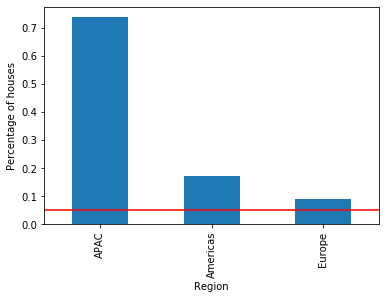

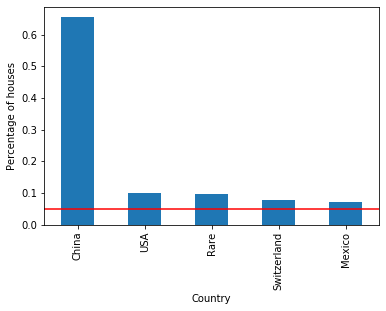

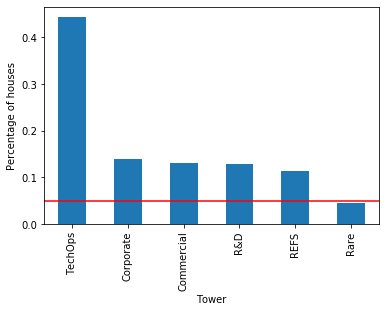

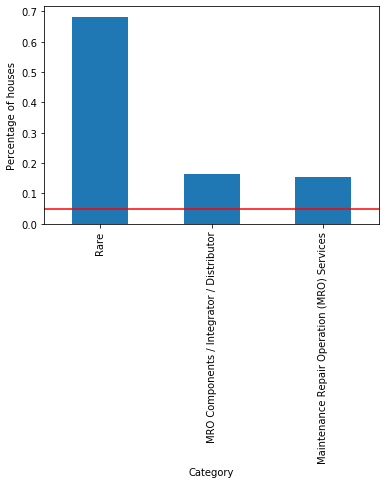

In [614]:
for col in ['Region', 'Country', 'Tower', 'Category']:

    temp_df = pd.Series(X_train[col].value_counts() / len(X_train) )

    # make plot with the above percentages
    fig = temp_df.sort_values(ascending=False).plot.bar()
    fig.set_xlabel(col)

    # add a line at 5 % to flag the threshold for rare categories
    fig.axhline(y=0.05, color='red')
    fig.set_ylabel('Percentage of houses')
    plt.show()

##### Catagorical Encoding

Going ahead with Frequency Encoding. Reason for this is, since we are planning for tree based algo, one hot encoding will not work. In addition frequency encoding adds additional information into data. It also doenot increase feature space.

In [626]:
count_enc = CountFrequencyCategoricalEncoder(encoding_method='count',
                                             variables=['Region', 'Country', 
                                                        'Tower', 'Category'])

count_enc.fit(X_train)

CountFrequencyCategoricalEncoder(variables=['Region', 'Country', 'Tower',
                                            'Category'])

In [627]:
count_enc.encoder_dict_

{'Region': {'APAC': 3629, 'Americas': 844, 'Europe': 444},
 'Country': {'China': 3218,
  'USA': 489,
  'Rare': 481,
  'Switzerland': 374,
  'Mexico': 355},
 'Tower': {'TechOps': 2180,
  'Corporate': 685,
  'Commercial': 638,
  'R&D': 628,
  'REFS': 561,
  'Rare': 225},
 'Category': {'Rare': 3356,
  'MRO Components / Integrator / Distributor': 806,
  'Maintenance Repair Operation (MRO) Services': 755}}

In [628]:
X_train = count_enc.transform(X_train)
X_test = count_enc.transform(X_test)

# Looking at the result
X_train.head()

,Supplier Name,Region,Country,Tower,Category
Final_Date,,,,,
2019-01,The Babcock & Wilcox Company,844,355,685,3356
2019-12,The Hershey Company,3629,3218,628,3356
2019-03,"Under Armour, Inc.",844,489,638,3356
2019-07,Arthur J. Gallagher & Co.,844,489,638,3356
2020-01,Stater Bros. Holdings Inc.,3629,3218,2180,755


#### Outlier Treatment

###### Plots after variable transformation

The feature is Avg_pr_M:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

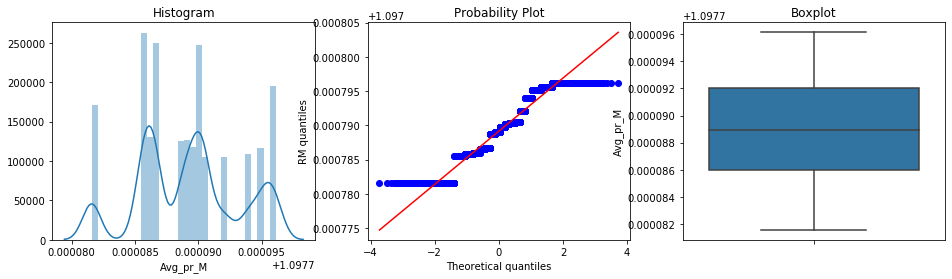

The feature is Avg_pr_M_pr_Tower:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

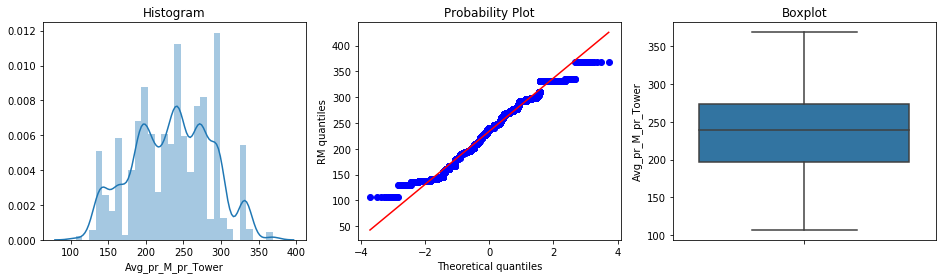

The feature is Avg_pr_M_pr_Category:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

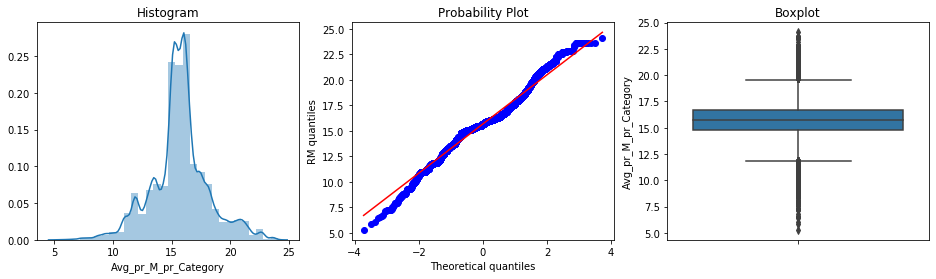

The feature is Avg_pr_M_pr_Country:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

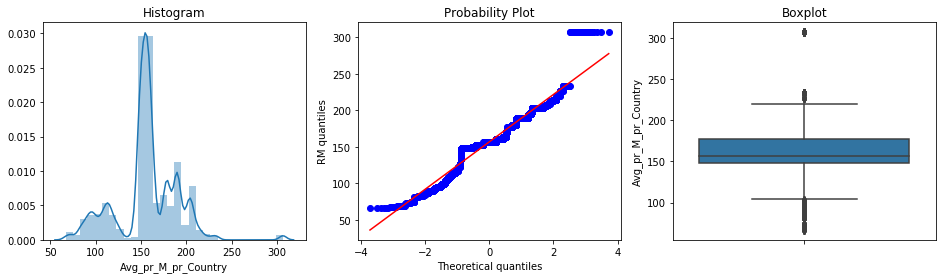

The feature is Avg_pr_M_pr_Region:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

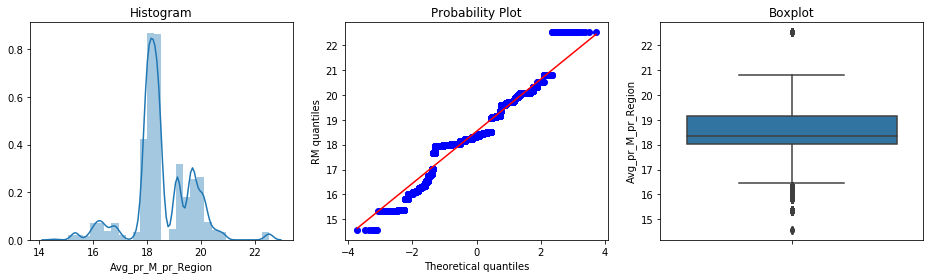

The feature is Avg_pr_M_pr_Vendor:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

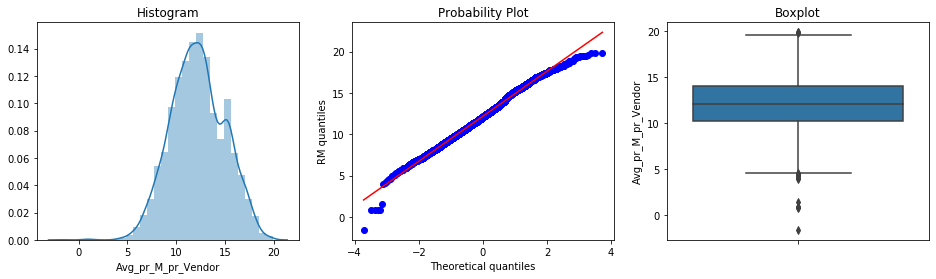

The feature is Spend:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

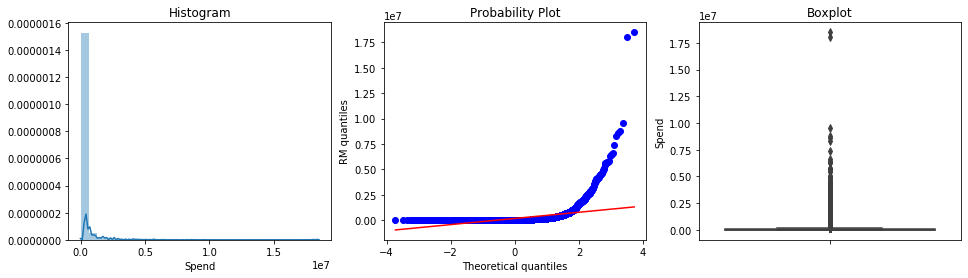

In [632]:
# Running diagonistic plot on transformed variables using box cox transformation i.e. data_tf1 
# from step 1.0.5.1

for column in ['Avg_pr_M', 'Avg_pr_M_pr_Tower', 'Avg_pr_M_pr_Category','Avg_pr_M_pr_Country', 
                'Avg_pr_M_pr_Region', 'Avg_pr_M_pr_Vendor', 'Spend']:
    print('The feature is {}:'.format(column))
    diagnostic_plots(data_tf1, column)

###### Winsorization to Treat Outlier

Winsorization is a way to minimize the influence of outliers in your data by either:
    1. Assigning the outlier a lower weight,
    2. Changing the value so that it is close to other values in the set.

In [634]:
windsoriser = Winsorizer(distribution='skewed', # choose skewed for IQR rule boundaries or gaussian for mean and std
                          tail='both', # cap left, right or both tails 
                          fold=1.5,
                          variables=['Avg_pr_M','Avg_pr_M_pr_Tower','Avg_pr_M_pr_Category',
                                     'Avg_pr_M_pr_Country','Avg_pr_M_pr_Region','Avg_pr_M_pr_Vendor'])

windsoriser.fit(data_tf1)

Winsorizer(distribution='skewed', fold=1.5, tail='both',
           variables=['Avg_pr_M', 'Avg_pr_M_pr_Tower', 'Avg_pr_M_pr_Category',
                      'Avg_pr_M_pr_Country', 'Avg_pr_M_pr_Region',
                      'Avg_pr_M_pr_Vendor'])

In [635]:
data_tf1_ROut = windsoriser.transform(data_tf1)

The feature is Avg_pr_M:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

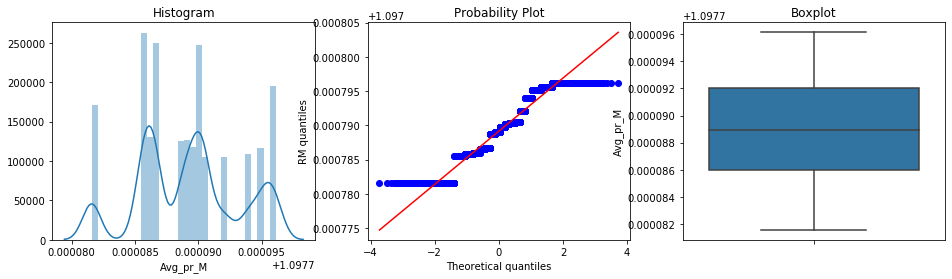

The feature is Avg_pr_M_pr_Tower:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

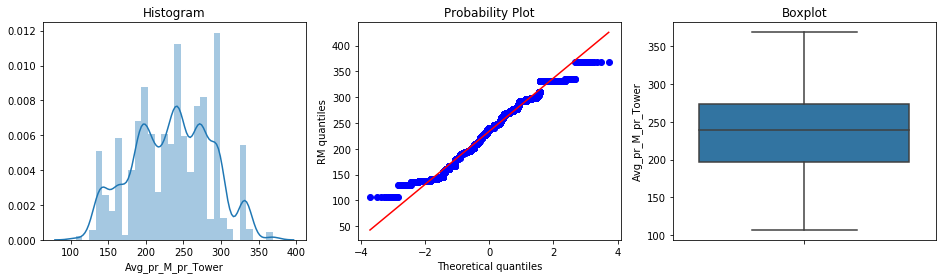

The feature is Avg_pr_M_pr_Category:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

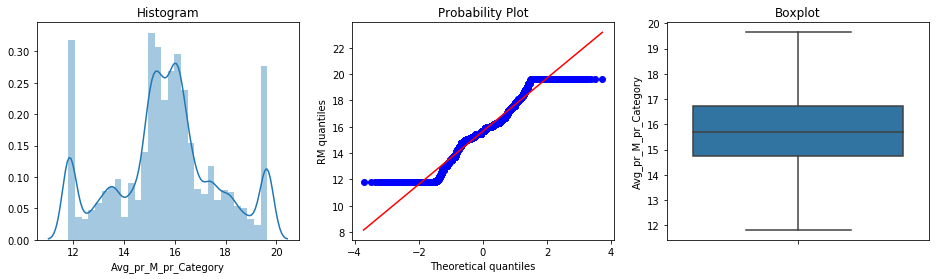

The feature is Avg_pr_M_pr_Country:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

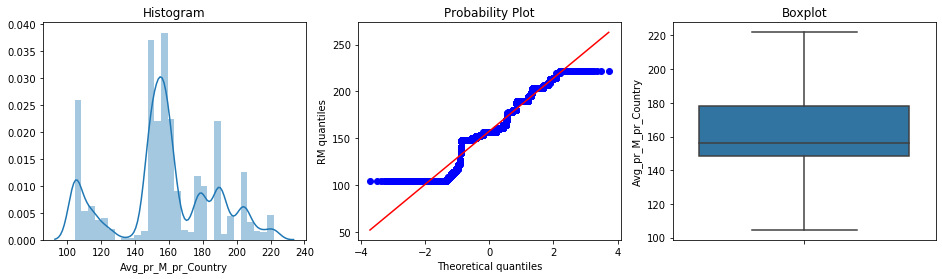

The feature is Avg_pr_M_pr_Region:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

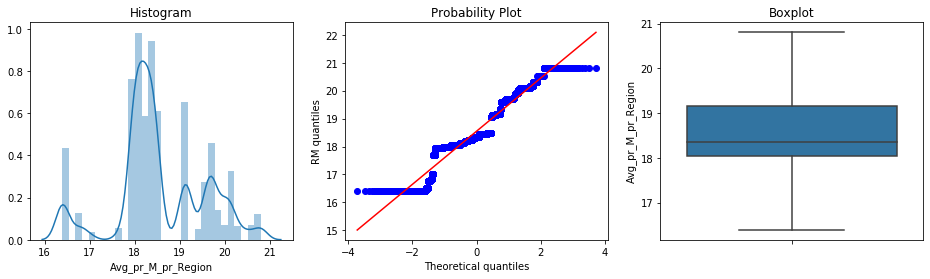

The feature is Avg_pr_M_pr_Vendor:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

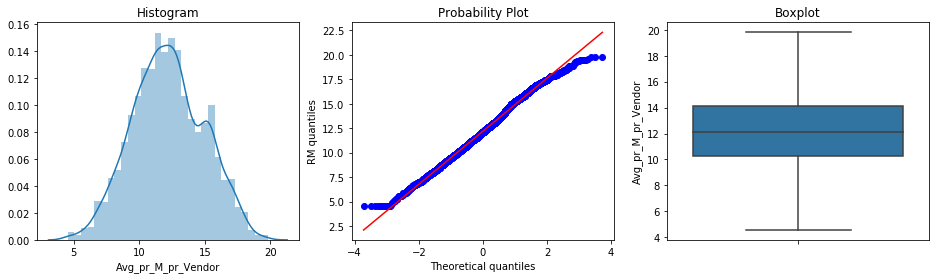

In [636]:
for column in ['Avg_pr_M', 'Avg_pr_M_pr_Tower', 'Avg_pr_M_pr_Category','Avg_pr_M_pr_Country', 
                'Avg_pr_M_pr_Region', 'Avg_pr_M_pr_Vendor']:
    print('The feature is {}:'.format(column))
    diagnostic_plots(data_tf1_ROut, column)

### Final Pipeline

#### Summary:

1. Read the data fresh from input file. 
2. Creating additional features.
3. Before Train Test split perform below steps:
    1. Variable Transformation Using Box Cox Method.
4. Perform Train-Test Split
5. Steps after Train-Test Split:
    1. Discretization. The features to be included are followed by ordinal encoding:
        1. Scaled_Country
        2. Scaled_Tower
    2. Rare Label Encoding on below features:
        1. Region
        2. Country
        3. Tower
        4. Category
    3. Perform Frequency Encoding on above variables.
    4. Outlier Treatment using winsorization on below variables:
        1. Avg_pr_M
        2. Avg_pr_M_pr_Tower
        3. Avg_pr_M_pr_Category
        4. Avg_pr_M_pr_Country
        5. Avg_pr_M_pr_Region
        6. Avg_pr_M_pr_Vendor
 6. Model Building    

#### Reading Data & Creating New Features

In [649]:
df.head(4)

,Supplier Name,Region,Country,Tower,Category,Spend,Avg_pr_M,Avg_pr_M_pr_Tower,Avg_pr_M_pr_Category,Avg_pr_M_pr_Country,Avg_pr_M_pr_Region,Avg_pr_M_pr_Vendor,Scaled_Tower,Scaled_Catagory,Scaled_Country,Scaled_Region,Scaled_Vendor
Final_Date,,,,,,,,,,,,,,,,,
2019-01,"AptarGroup, Inc.",APAC,China,R&D,Laboratory Equipment Services and Parts,964537.590650,109290.666602,76869.416233,119281.653576,121275.831388,113822.506881,964537.590650,0.703348,1.091417,1.109663,1.041466,8.825434
2019-01,UnitedHealth Group,APAC,India,IT,IT Hardware,1609.153631,109290.666602,38833.989011,1886.232363,34003.078873,113822.506881,1409.835890,0.355328,0.017259,0.311125,1.041466,0.012900
2019-01,UnitedHealth Group,Americas,USA,IT,IT Hardware,1210.518148,109290.666602,38833.989011,1886.232363,117454.202293,121915.769437,1409.835890,0.355328,0.017259,1.074696,1.115519,0.012900
2019-01,"Ferrellgas Partners, L.P.",APAC,China,TechOps,Maintenance Repair Operation (MRO) Services,158519.945582,109290.666602,165618.041715,82273.225450,121275.831388,113822.506881,87954.545461,1.515391,0.752793,1.109663,1.041466,0.804776


#### Variable Transformation Using box cox

In [650]:
lt1 = vt.BoxCoxTransformer(variables = ['Avg_pr_M','Avg_pr_M_pr_Tower','Avg_pr_M_pr_Category',
                                        'Avg_pr_M_pr_Country','Avg_pr_M_pr_Region',
                                        'Avg_pr_M_pr_Vendor'])
lt1.fit(df)
df = lt1.transform(df)

In [651]:
df.head(2)

,Supplier Name,Region,Country,Tower,Category,Spend,Avg_pr_M,Avg_pr_M_pr_Tower,Avg_pr_M_pr_Category,Avg_pr_M_pr_Country,Avg_pr_M_pr_Region,Avg_pr_M_pr_Vendor,Scaled_Tower,Scaled_Catagory,Scaled_Country,Scaled_Region,Scaled_Vendor
Final_Date,,,,,,,,,,,,,,,,,
2019-01,"AptarGroup, Inc.",APAC,China,R&D,Laboratory Equipment Services and Parts,964537.590650,1.097782,183.237297,16.611512,148.494774,17.990112,17.09906,0.703348,1.091417,1.109663,1.041466,8.825434
2019-01,UnitedHealth Group,APAC,India,IT,IT Hardware,1609.153631,1.097782,140.954023,9.422373,95.874621,17.990112,8.10884,0.355328,0.017259,0.311125,1.041466,0.012900


#### Train Test Split

In [652]:
df.columns

Index(['Supplier Name', 'Region', 'Country', 'Tower', 'Category', 'Spend',
       'Avg_pr_M', 'Avg_pr_M_pr_Tower', 'Avg_pr_M_pr_Category',
       'Avg_pr_M_pr_Country', 'Avg_pr_M_pr_Region', 'Avg_pr_M_pr_Vendor',
       'Scaled_Tower', 'Scaled_Catagory', 'Scaled_Country', 'Scaled_Region',
       'Scaled_Vendor'],
      dtype='object')

In [653]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['Spend','Scaled_Catagory','Scaled_Region','Scaled_Vendor'],axis=1),  # predictors
    df['Spend'],  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

<IPython.core.display.Javascript object>

((5620, 13), (1405, 13))

#### Pipeline

In [ ]:
DEF_pipe = Pipeline([

    # discretization & ordinal encoding
    ('discrit',
     EqualFrequencyDiscretiser(q=10, variables=['Scaled_Tower','Scaled_Country']
                               return_object=True)),
    ('ord_enc',
     OrdinalCategoricalEncoder(encoding_method = 'ordered'
                               variables=['Scaled_Tower','Scaled_Country'])),

    # Rare Label Encoding and Catagorical(frequency) Encoding
    ('encoder_rare_label',
     RareLabelCategoricalEncoder(tol=0.05, n_categories=2,
                                 variables=['Region','Country','Tower','Category'])),
    
    ('categorical_encoder',
     CountFrequencyCategoricalEncoder(encoding_method='count',
                                      variables=['Region','Country','Tower','Category'])),
     
    # Outlier Treatment
    ('winsorization',
     Winsorizer(distribution='skewed', tail='both', fold=1.5,
                variables=['Avg_pr_M','Avg_pr_M_pr_Tower','Avg_pr_M_pr_Category',
                           'Avg_pr_M_pr_Country','Avg_pr_M_pr_Region','Avg_pr_M_pr_Vendor'])),

    # Gradient Boosted machine
    ('dt', DecisionTreeRegressor(random_state=10))
     
])

In [ ]:
param_grid = {
    'encoder_rare_label__tol': [0.1, 0.03]
}

In [ ]:
grid_search = GridSearchCV(DEF_pipe, param_grid,
                           cv=5, n_jobs=-1, scoring='roc_auc')

In [ ]:
grid_search.fit(X_train, y_train)

# and we print the best score over the train set
print(("best roc-auc from grid search: %.3f"
       % grid_search.score(X_train, y_train)))